# VGG16 pretrained

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.utils import plot_model 
import os
import numpy as np
import matplotlib.pyplot as plt
from contextlib import redirect_stdout
import pandas as pd
import pydot_ng as pydot

## Getting and saving the data

In [7]:
# CONFIGURE
local_path = "/home/sciapps/Documents/Repos/tfm"
model_name = "vgg16_b1_trained_5_class"

In [8]:
# DATA SET DIRECTORIES
source_dir = "data/images/image_preprocessing/processed_images_train_test/"
train_dir = os.path.join(local_path, source_dir, "train")
test_dir = os.path.join(local_path, source_dir, "test")

In [9]:
# OUTPUTS
save_dir = os.path.join(local_path, "models", "images", "outputs", model_name)
# Create outputs folder
if not os.path.exists(save_dir):
    os.mkdir(save_dir)

In [10]:
# LABELS
class_names = sorted(os.listdir(train_dir))
print(class_names)

['Euonymus_europaea', 'Fagus_sylvatica', 'Frangula_alnus', 'Fraxinus_excelsior', 'Ilex_aquifolium']


## Image decodification

`ImageDataGenrator`:

- Read images from the disk.
- Decode images in arrays of float pixel values (here RGB).
- Rescale the floats in the arrays from values between 0 and 255 to 0 and 1.
- Perform real-time image augmentation.

`flow_from_directory`:

- Generate the batches of array image data (aka tensors) with the real-time data augmentation defined in the `ImageDataGenerator`.
- Resize the arrays.

In [11]:
# CONFIGURATION ImageDataGenerator 
img_height = 224 
img_width = 224
color_mode= "rgb"
class_mode="categorical"                                  
shuffle=True                                                               
seed = 1234 

In [12]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(15,15))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

### Without augmentation

In [13]:
train_datagen_no_aug = ImageDataGenerator(rescale=1./255)  
train_array_no_aug = train_datagen_no_aug.flow_from_directory(directory = train_dir,
                                            target_size=(img_width, img_height),
                                            color_mode = color_mode,
                                            shuffle = shuffle,
                                            class_mode = class_mode,
                                            subset = "training",
                                            seed=seed
                                            ) 

Found 988 images belonging to 5 classes.


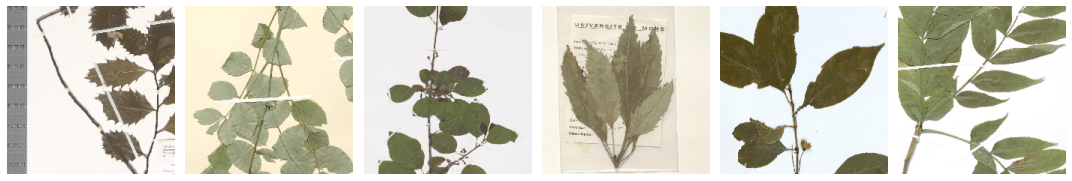

In [14]:
sample_training_images, _ = next(train_array_no_aug)
plot_images(sample_training_images[:24])


### Applying augmentation

Aim: increase the number of examples by randomly applying transformations to the original images. It also prevents overfitting of the model. 

Augmnetation methods applied:

- Rotation
- Vertica flip
- Horizontal flip
- Brightness range  (Values less than 1.0 darken the image, e.g. [0.5, 1.0], whereas values larger than 1.0 brighten the image, e.g. [1.0, 1.5], where 1.0 has no effect on brightness)
- Zooming
- Shear range

Fill mode for empty pixels when rotating the image is set to "reflect", so that, being the letters between brachets the pixels of the image, the area outside is filled as follow: abcddcba|abcd|dcbaabcd

In [15]:
# Test and validation datasets

train_datagen = ImageDataGenerator(rescale=1./255,
                                            brightness_range = [0.2,1.5],
                                            zoom_range = [0.5,1.0],
                                            rotation_range=45,
                                            horizontal_flip=True,
                                            vertical_flip=True,
                                            shear_range = 0.2,
                                            fill_mode = "reflect",
                                            validation_split = 0.20) 

train_array = train_datagen.flow_from_directory(directory = train_dir,
                                            target_size=(img_width, img_height),
                                            color_mode = color_mode,
                                            shuffle = shuffle,
                                            class_mode = class_mode,
                                            subset = "training",
                                            seed=seed
                                            ) 

validation_array = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(img_width, img_height),
                                                    color_mode = color_mode,
                                                    class_mode= class_mode,
                                                    subset='validation',
                                                    seed=seed)

Found 793 images belonging to 5 classes.
Found 195 images belonging to 5 classes.


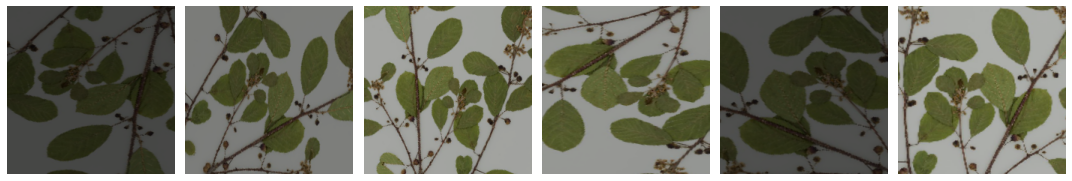

In [16]:
augmented_images = [train_array[0][0][0] for i in range(24)]
plot_images(augmented_images)

## Creating and training the model

### Model network architecture

The simplest network architecture constists of 3 layers:
- Input layer, with a number of nodes equal to the number of features in the model.
- Hidden layer, with a variable number of nodes. 
- Output layer, with a number of nodes equal to the number of classes. 

#### The hidden layers

The hidden layers can have different characteristics depending of their use. 
For image classification, at least one of the hidden layers will be convolutional.

##### The convolutional layer

The main characteristic of a convolutional layer is that it applies a filter to each of the elements of a matrix (the pixels of an image). This filter is called the **kernel**. The kernel is a matrix (generally of small size, 2x3, 3x2, 3x3...) with a set of fixed real numbers. Each pixel of the original image is multiplied by the kernel matrix and the result sumed up to output another pixel value for the transformed image. Each time the filter is applied to all the pixels of an image is called a **convolution**.

At this level , the performance of the image feature extraction depends on the values in the kernel and the concatenation of convolutional layers. This is because different filters may be specialized in extracting different features (for example, vertical or horizontal edges) and the sequential input and output values for each layer improves the final output.

In keras, the convolutional layer applied to a 2D matrix is called `Conv2D`.

##### The fully connected layer

A fully connected layer is an all purpose layer where each node receive the inputs from all the nodes from the previous layer, multiplied by their weights, sumed and transformed by the activation funcion.

In keras, the fully connected layer is called `Dense`.


##### MaxPooling2D


##### Flatten



### Creating the model with `Keras`

In `Keras` the model is defined with the `Sequential` method as a linear stack ot layers. The **input layer** is implicit in the first layer (a network with 3 layers will have 2 in `keras Sequential` method).

The **input shape** is into the first layer. The model inputs are the tensors or arrays. Images have 3 dimensions: **width**, **height** and **channels**. The width and the height are measured in pixels and the channels reference the color values (the channel value is 1 if it is in black and white and 3 if it is color in RGB (Red, Green, blue) or HSV (hue, saturation, value) formats - 2 and 4 are black and white or color with an alpha channel (transparency). 

The **activation function** that has to be specified in each layer transforms the input data so that the output doen't have a linear relation with the input. 

### Transfer learning with `Keras`

Aim: to use a pre-existing model that has performed well carrying out a similar task. 

#### VGG16

Ref: 2014 ImageNet competition


In [17]:
# load pre-trained model with the weights
vgg16_model = tf.keras.applications.VGG16()


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [18]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [19]:
# Add the layers of vgg16 model to a new sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]: # remove last layer
    model.add(layer)
# Rename model
model._name = model_name
model.name

'vgg16_b1_trained_5_class'

In [20]:
# Freeze the weights in the layers
for layer in model.layers[:4]:
    layer.trainable = False
for layer in model.layers[4:]:
    layer.trainable = True
# Add last layer for categories
model.add(Dense(len(class_names), activation = "softmax"))

In [21]:
model.summary()

Model: "vgg16_b1_trained_5_class"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56

The non-trainable parameters are no longer 0, since it has been selected to freeze the weights.

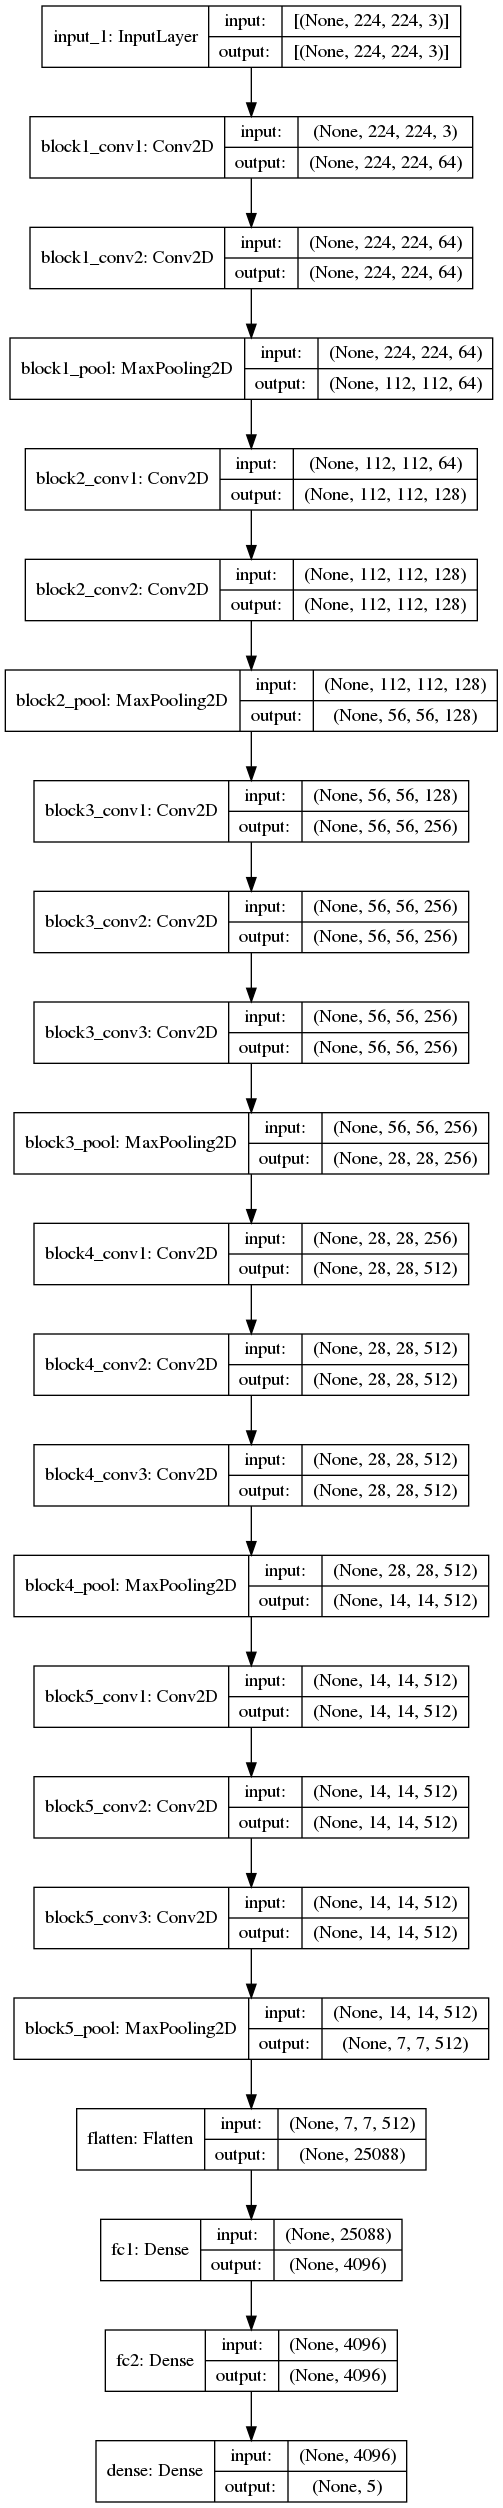

In [22]:
# Plot model architecture and save it as .png
rankdir = "TB" # TB: vertical; LR: horizontal
plot_model(model, to_file = os.path.join(save_dir,"model_plot.png"), 
           show_shapes=True, show_layer_names = True, rankdir = rankdir)

### Training the model

The parameters from the model above represent the **weights**. 
A weight is a number that multiplies the value of the **input node** before passing it to the **output node** in the next layer. 
An output node receive the values from each of the input nodes multiplied by their weights, after they have been sumed and transformed by the **activation function**.


Training the model means to adjust the values of the weights in the subsequent runs (the **epochs**. In every run, the weights are modified based on an optimization algorithm or **optimizer**.
This algorithm tries to minimize the **loss function**. In every run, the model predicts the classes with a certain probability. The loss function measures, through that probability, the error of the predictions. In this context, the **gradient** is the computation of the error in relation to the weight (it is the derivative of the error divided into the derivative of the weight). The gradient is multiplied by a **learning rate** to obtain the new weights. The value of the learning rate is in the order of 10^-3.

**Stocastic gradient descent** (sgd) is one type of optimizer. There are also different types of loss functions, like the **sparse categorical crossentropy**. The value of the optimizer 

#### Configuration

- Epoch: the number of iterations through the network in order to adjust the weights. In general, the higher number of epochs, the better the performance, up to a limit. 
- Batch size: the number of examples passed at a time. If the batch size is equal to the number of examples in the training dataset, then we have one batch per epoch. This is computationally costly and may be limited by the machine power. If the batch size is smaller, then there would be several runs per epoch. If it is too small, the training may be too slow.  

In [23]:
# CONFIGURE
batch_size = len(train_array)//4
epochs = 30  
steps_per_epoch = 4

In [24]:
# COMPILING THE MODEL
# SparseCategoricalCrossentropi directly uses classes labels,
## so that they don't need to be numerically encoded.
optimizer = "sgd" # Options: "sgd", "adam"
model.compile(optimizer=optimizer,
            loss = "categorical_crossentropy",
            metrics=['accuracy'])

In [25]:
# TRAINING THE MODEL
history = model.fit_generator(
    train_array,
    #batch_size = batch_size,
    steps_per_epoch= 4,
    epochs=epochs,
    verbose=1, # get a progress bar and ETA
    validation_data=validation_array,
    validation_steps=2 # batch_size
)

Epoch 1/30
4/4 [==============================] - 344s 86s/step - loss: 12.5430 - acc: 0.1562 - val_loss: 3.0141 - val_acc: 0.2031
Epoch 2/30
4/4 [==============================] - 352s 88s/step - loss: 2.6895 - acc: 0.2422 - val_loss: 1.6790 - val_acc: 0.2188
Epoch 3/30
4/4 [==============================] - 341s 85s/step - loss: 1.6227 - acc: 0.1736 - val_loss: 1.5874 - val_acc: 0.2031
Epoch 4/30
4/4 [==============================] - 354s 89s/step - loss: 1.5608 - acc: 0.2500 - val_loss: 1.5939 - val_acc: 0.2031
Epoch 5/30
4/4 [==============================] - 362s 90s/step - loss: 1.5943 - acc: 0.2656 - val_loss: 1.5968 - val_acc: 0.1719
Epoch 6/30
4/4 [==============================] - 357s 89s/step - loss: 1.5551 - acc: 0.2578 - val_loss: 1.5536 - val_acc: 0.2969
Epoch 7/30
4/4 [==============================] - 358s 90s/step - loss: 1.5700 - acc: 0.3203 - val_loss: 1.5510 - val_acc: 0.3125
Epoch 8/30
4/4 [==============================] - 356s 89s/step - loss: 1.5533 - acc: 0.3

### Evaluating the model training

#### Accuracy and loss during training

In [26]:
# Parameters measured during model training
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


In [27]:
acc = history_dict["acc"]
val_acc = history_dict["val_acc"]
loss = history_dict["loss"]
val_loss = history_dict["val_loss"]
epochs_range = range(epochs)

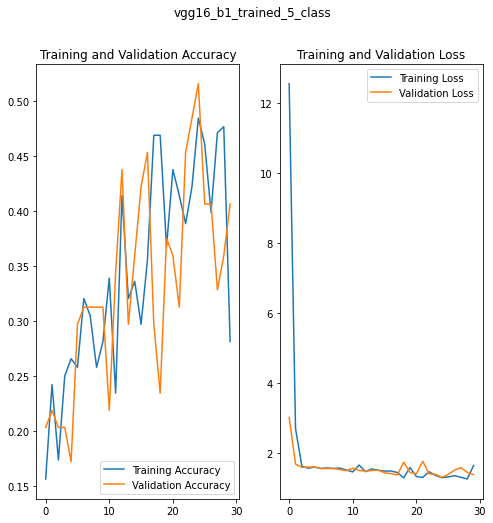

In [28]:
plt.figure(figsize=(8, 8))
plt.suptitle(model_name)
# Accuracy plots
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label="Training Accuracy")
plt.plot(epochs_range, val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")
# Loss plots
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label="Training Loss") 
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.savefig(os.path.join(save_dir,"acc_loss_plot.png"))
plt.show()

#### Overfitting

When the model predicts significantly better the training set than the validation set, it is a sign of overfitting. 

### Saving model, model summary and outputs

In [29]:
# EDIT FOR EACH MODEL
# Model description
model_description = f"""
{model_name}
# load pre-trained model with the weights
vgg16_model = tf.keras.applications.VGG16()
# Add the layers of vgg16 model to a new sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]: # remove last layer
    model.add(layer)
# Freeze the weights in the layers
for layer in model.layers:
    layer.trainable = False
# Add last layer for categories
model.add(Dense(len(class_names), activation = "softmax"))
"""

Saving the model means saving:

- the model's configuration (topology)
- the model's weights
- the model's optimizer's state (if any)


In [ ]:
# Save model
model.save_weights(os.path.join(save_dir, "weights.h5")) 

In [30]:
# Save model weights independently
model.save(os.path.join(save_dir, "model.h5"))

To load the model again, it has to be built and then the weights added:

```
# load pre-trained model with the weights
vgg16_model = tf.keras.applications.VGG16()
# Add the layers of vgg16 model to a new sequential model 
model = Sequential()
for layer in vgg16_model.layers[:-1]: # remove last layer
    model.add(layer)
# Freeze the weights in the layers
for layer in model.layers:
    layer.trainable = False
# Add last layer for categories
model.add(Dense(len(class_names), activation = "softmax"))  

cnn.load_weights(os.path.join(save_dir, "model.h5"))
```

In [31]:
# Save model description
with open(os.path.join(save_dir,"model_description.txt"), "w") as file:
    with redirect_stdout(file):
        print(model_description)

In [32]:
# Save model summary
with open(os.path.join(save_dir,"model_summary.txt"), "w") as file:
    with redirect_stdout(file):
        model.summary()

In [33]:
# Save model history to csv
history_df = pd.DataFrame(history.history) 
history_df.to_csv(os.path.join(save_dir, "model_history.csv"), sep=",", index=False)

To get back the accuracy and loss data:

- Open the CSV with the model history.
- Save it to a dictionary.

```
history_df = pd.read_csv(os.path.join(save_dir, "model_history.csv"))
history = history_df.to_dict()
```

## Evaluating the model

### Get the test dataset

In [ ]:
# Test dataset
test_main_dir = os.path.join(local_path, source_dir)
test_batch_size = len(os.listdir(test_dir)) 
test_datagen = ImageDataGenerator(rescale=1./255)  
test_array = test_datagen.flow_from_directory(directory = test_main_dir,  
                                                    classes = ["test"],
                                                    batch_size = test_batch_size,
                                                    target_size=(img_width, img_height),
                                                    color_mode = color_mode,
                                                    shuffle = False,
                                                    class_mode= None,
                                                    seed=seed) 

In [28]:
# TEST LABELS
def get_test_labels(test_files):
    """
    Return a list of labels: 
        "Genus_species"
    Arg.: a list of file names with the structure:
          "Genus_species_occurrencenumber.jpg",
          where Genus_species is the class name,   
    """
    test_labels = []
    for i in range(len(test_files)):
        test_file_split = test_files[i].split("_")
        # Remove occurence number and file extension
        class_name_splitted = test_file_split[:-1]
        class_name = "_".join(class_name_splitted)
        test_labels.append(class_name)
    return test_labels

In [29]:
def test_labels_to_index(test_labels, class_names):
    """
    Return a 1D array of integers with the corresponding
    number for a class.
    Args.: - A list with the class name of each item in 
          the test data set.
           - A sorted list with the possible class names. 
    Eg.: test_labels[1] = "Buxus_sempervirens" corresponds to index 4
         in the list of class names.
    """
    test_labels_index = []
    for i in range(len(test_labels)):
        ind = class_names.index(test_labels[i])
        test_labels_index.append(ind)
    return np.array(test_labels_index)

In [30]:
test_files = os.listdir(test_dir)
test_labels = get_test_labels(test_files)
test_labels[:5]

['Acer_campestre',
 'Buxus_sempervirens',
 'Corylus_avellana',
 'Crataegus_monogyna',
 'Salix_caprea']

In [31]:
test_labels_index = test_labels_to_index(test_labels, class_names)
test_labels_index[:5]

array([ 0,  4,  7,  9, 26])

### Predict the probability of classifiying each class

In [32]:
# Get the probability of predicting each class for each image
predictions = model.predict_generator(test_array,steps=1,verbose=1)

1/1 [==============================] - 53s 53s/step


Predictions is a 2D array with a shape: (number of examples in test, number of classes)

In [33]:
predictions.shape

(72, 42)

In [34]:
# Get predicted class for each example
def predicted_class(predictions):
    """
    Return a 1D array with the predicted class for each example.
    Arg.: 2D array predictions of shape (number of examples, number of classes)
    """
    pred_class = []
    for i in range(len(predictions)):
        higher_prob = max(predictions[i])
        ind, = np.where(np.isclose(predictions[i], higher_prob))
        pred_class.append(ind[0])
    return np.array(pred_class)

pred_class = predicted_class(predictions)

### Plot the confussion matrix

In [35]:
test_labels_index

array([ 0,  4,  7,  9, 26, 31, 34,  6,  1, 29, 26, 13,  3, 28, 11, 23, 18,
       35,  2,  5, 39, 24, 40, 19,  3, 27,  8, 15, 41, 17, 30, 20, 14,  2,
       11, 39, 31,  5,  3, 37, 32, 17,  9, 24,  7, 40,  1, 18, 28, 10, 40,
       11, 12, 24, 25,  9, 15,  2, 39, 33,  4, 10,  0,  7, 32, 25,  1, 12,
       22, 36, 17, 14])

In [36]:
pred_class

array([40, 40, 40,  2, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
       40,  6, 40, 40, 40, 40, 40,  6, 40, 40, 40, 40, 40,  6, 40, 15, 15,
        2, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,  2, 40, 40, 40,  3,  2,
       40, 15, 40, 15, 40, 40,  6, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        6, 40, 40, 40])

In [45]:
# Build the confusion matrix
cm = tf.math.confusion_matrix(test_labels_index, pred_class) 
# Convert from tensor to array
sess = tf.Session()
conf_mat = sess.run(cm)
conf_mat

array([[0, 0, 0, ..., 0, 2, 0],
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 3, 0],
       [0, 0, 2, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=int32)

In [46]:
def plot_confusion_matrix(cm, class_names, model_name):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.

    Args:
    cm (array, shape = [n, n]): a confusion matrix of integer classes
    class_names (array, shape = [n]): String names of the integer classes
    """
    figure = plt.figure(figsize=(20, 20))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title("Confusion matrix - "+ model_name, fontsize = 22)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.savefig(os.path.join(save_dir,"conf_matrix.png"))


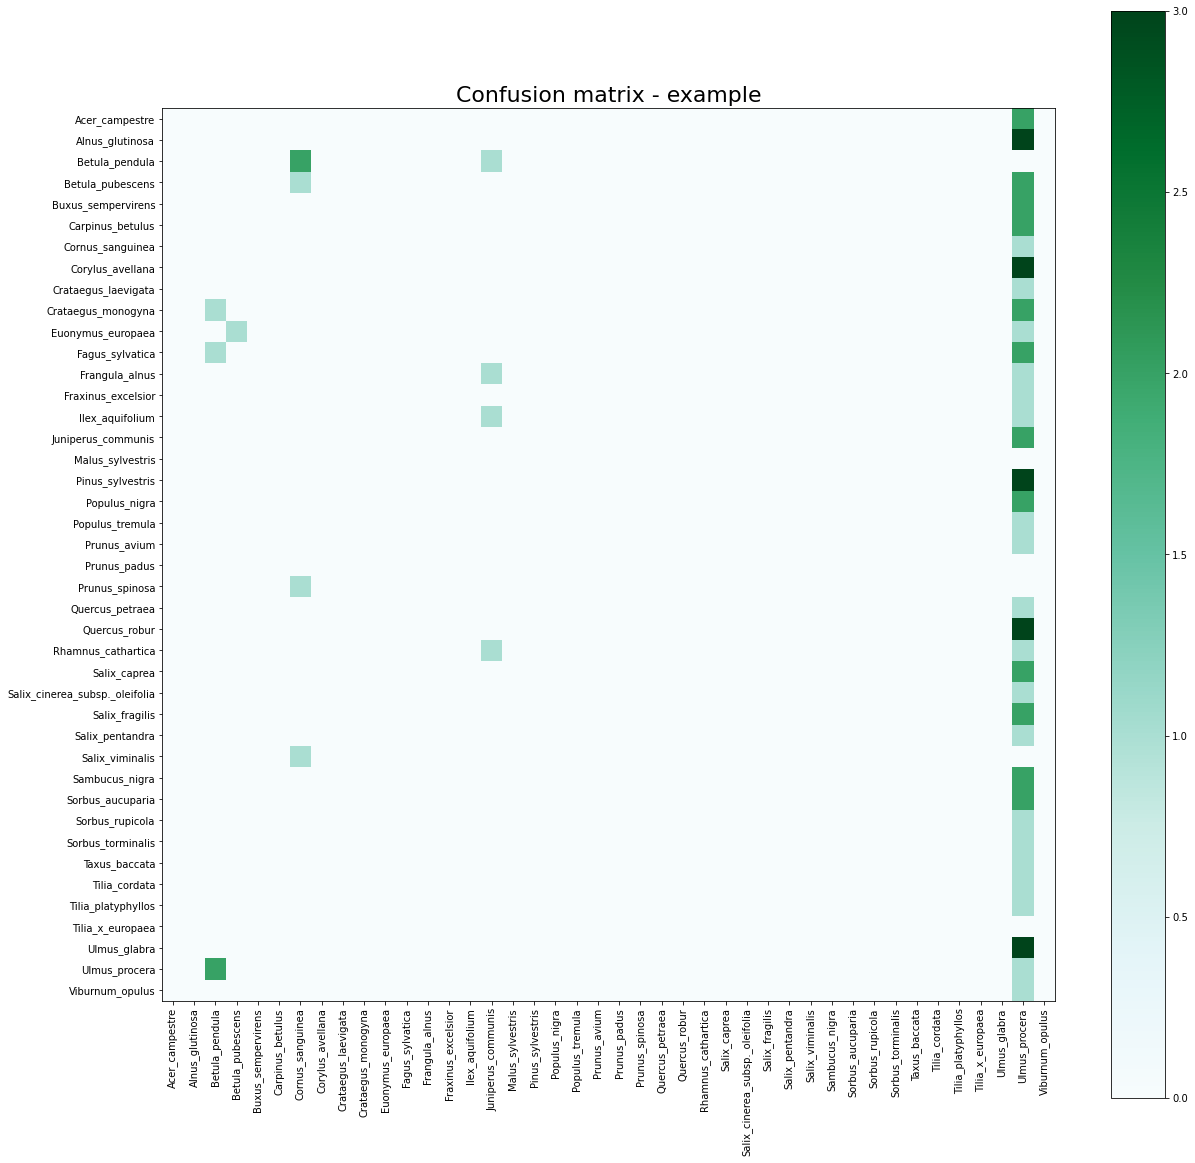

In [47]:
plot_confusion_matrix(conf_mat, np.array(class_names), model_name)